In [2]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"

import json, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

DATA_DIR   = "../generated/bulk_50k"
OUT_DIR    = "../data/models/cnn"
PLOT_DIR   = "../plots"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

EPOCHS      = 200
BATCH_SIZE  = 64
LR          = 1e-3
PATIENCE    = 30
RANDOM_SEED = 42

TRAIN_FRAC = 0.85
VAL_FRAC   = 0.10
TEST_FRAC  = 0.05

# CNN hyperparams
CNN_BLOCKS   = 2
CNN_FILTERS  = 32
CNN_KERNEL   = 7
CNN_POOL     = 2
DROPOUT      = 0.15

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [3]:
meta = json.load(open(os.path.join(DATA_DIR, "meta.json")))
shards = sorted([os.path.join(DATA_DIR, f)
                 for f in os.listdir(DATA_DIR) if f.endswith(".npz")])

X_list, y_list = [], []
for sp in shards:
    d = np.load(sp)
    X_list.append(d["X"])
    y_list.append(d["y_hbn"])
    wn = d["wn"]
X = np.vstack(X_list).astype(np.float32)
y = np.concatenate(y_list).astype(np.float32)
print("Loaded:", X.shape, y.shape, "axis:", wn.shape)


Loaded: (50000, 3323) (50000,) axis: (3323,)


In [4]:
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=(1.0-TRAIN_FRAC), random_state=RANDOM_SEED, shuffle=True
)
val_ratio_of_tmp = VAL_FRAC / (VAL_FRAC + TEST_FRAC)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=(1.0 - val_ratio_of_tmp), random_state=RANDOM_SEED, shuffle=True
)

mean = X_train.mean(axis=0, dtype=np.float64)
std  = X_train.std(axis=0, dtype=np.float64)
std[std < 1e-12] = 1.0

X_train_s = ((X_train - mean) / std).astype(np.float32)
X_val_s   = ((X_val   - mean) / std).astype(np.float32)
X_test_s  = ((X_test  - mean) / std).astype(np.float32)

# CNN expects (N, L, 1)
X_train_s = X_train_s[..., None]
X_val_s   = X_val_s[..., None]
X_test_s  = X_test_s[..., None]

print("Shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)


Shapes: (42499, 3323, 1) (5000, 3323, 1) (2501, 3323, 1)


In [5]:
def build_cnn1d(input_len, dropout=0.0, lr=1e-3,
                blocks=3, base_filters=64, kernel_size=9, pool_size=2):
    inp = keras.Input(shape=(input_len, 1))
    x = inp
    filters = base_filters
    for _ in range(blocks):
        x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu")(x)
        x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu")(x)
        x = layers.MaxPooling1D(pool_size=pool_size)(x)
        if dropout > 0:
            x = layers.Dropout(dropout)(x)
        filters = max(filters // 2, 16)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="linear")(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="mse", metrics=["mae"])   # <= your working line
    return model

model = build_cnn1d(X_train_s.shape[1], dropout=DROPOUT, lr=LR,
                    blocks=CNN_BLOCKS, base_filters=CNN_FILTERS,
                    kernel_size=CNN_KERNEL, pool_size=CNN_POOL)
model.summary()



I0000 00:00:1764224558.309277  893359 gpu_device.cc:2411] Ignoring visible gpu device (device: 4, name: NVIDIA T400 4GB, pci bus id: 0000:e3:00.0, compute capability: 7.5) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2025-11-27 15:22:38.930414: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1764224558.930703  893359 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18757 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:31:00.0, compute capability: 8.6
2025-11-27 15:22:38.931189: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1764224558.931478  8

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3323, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3323, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3323, 32)       │         7,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1661, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1661, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1661, 16)       │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1661, 16)       │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 830, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 830, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,399,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,413,057 (13.02 MB)

 Trainable params: 3,413,057 (13.02 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
es  = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                  patience=max(5, PATIENCE//3), min_lr=1e-6)

hist = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[es, rlr]
)


Epoch 1/200


2025-11-27 15:22:42.720183: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f2c2800f4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-27 15:22:42.720222: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-11-27 15:22:42.720228: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2025-11-27 15:22:42.720232: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (2): NVIDIA RTX A5000, Compute Capability 8.6
2025-11-27 15:22:42.720237: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (3): NVIDIA RTX A5000, Compute Capability 8.6
2025-11-27 15:22:42.785762: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-27 15:22:43.127268: I exter

 15/665 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 473.5501 - mae: 17.9026 

I0000 00:00:1764224568.854014  893924 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 8.3779 - mae: 1.3976 - val_loss: 14.9429 - val_mae: 3.5903 - learning_rate: 0.0010
Epoch 2/200
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 1.7171 - mae: 0.9395 - val_loss: 4.8051 - val_mae: 2.0001 - learning_rate: 0.0010
Epoch 3/200
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 1.6585 - mae: 0.9120 - val_loss: 7.7296 - val_mae: 2.5550 - learning_rate: 0.0010
Epoch 4/200
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 1.6662 - mae: 0.9186 - val_loss: 27.1786 - val_mae: 4.2858 - learning_rate: 0.0010
Epoch 5/200
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 1.6909 - mae: 0.9193 - val_loss: 5.8789 - val_mae: 2.1588 - learning_rate: 0.0010
Epoch 6/200
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 1.5503 - mae: 0.8908 - val_loss: 4.8642 - val_mae: 1.8223 - learning_rate: 0.0010
Epoch 7/200
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 1.5432 - mae: 0.8897 - val_loss: 1.0606 - val_mae: 0.8266 - learning_rate: 0.

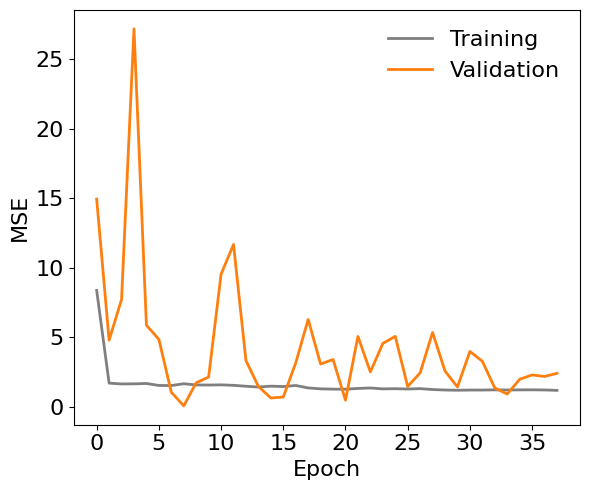

Saved: ../plots/fig_s3a.jpg


In [ ]:
plt.figure(figsize=(6,5))

# custom line colors
TRAIN_COLOR = "tab:gray"
VAL_COLOR   = "tab:orange"

# plot curves
plt.plot(hist.history["loss"], label="Training", color=TRAIN_COLOR, lw=2)
plt.plot(hist.history["val_loss"], label="Validation", color=VAL_COLOR, lw=2)

# labels and ticks
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("MSE", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# legend font control
plt.legend(fontsize=16, loc="best", frameon=False)

plt.tight_layout()
lc_path = os.path.join(PLOT_DIR, "fig_3a.jpg")
plt.savefig(lc_path, dpi=500)
plt.show()
print("Saved:", lc_path)


TRAIN  MAE=0.225  RMSE=0.283  R²=1.000
TEST  MAE=0.226  RMSE=0.285  R²=1.000


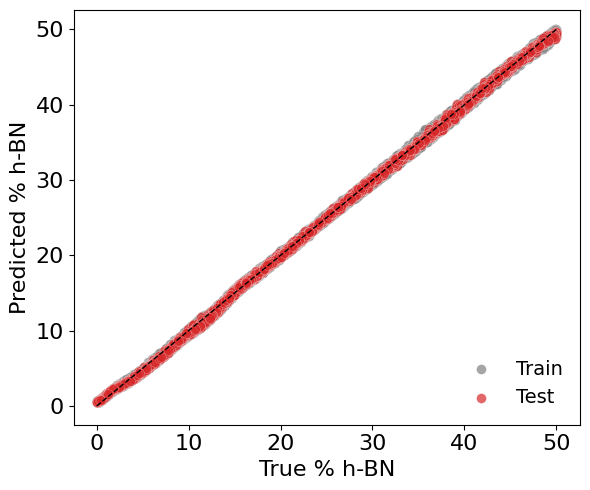

Saved: ../plots/fig_s3b.jpg


In [ ]:
def reg_metrics(y_true, y_pred, name=""):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(((y_true - y_pred)**2).mean())
    r2   = r2_score(y_true, y_pred)
    print(f"{name}  MAE={mae:.3f}  RMSE={rmse:.3f}  R²={r2:.3f}")
    return mae, rmse, r2

y_tr_pred = model.predict(X_train_s, verbose=0).ravel()
y_te_pred = model.predict(X_test_s,  verbose=0).ravel()

reg_metrics(y_train, y_tr_pred, "TRAIN")
reg_metrics(y_test,  y_te_pred, "TEST")


# ---- viz style (from your viz.txt) ----
FIGSIZE_PARITY = (6, 5)
DPI            = 500
FONT           = 16
SCATTER_ALPHA  = 0.7
SCATTER_SIZE   = 50
EDGE_W         = 0.2

plt.figure(figsize=FIGSIZE_PARITY)

# ---- Train scatter ----
plt.scatter(
    y_train, y_tr_pred,
    color="tab:gray", alpha=SCATTER_ALPHA,
    s=SCATTER_SIZE, edgecolor="w", linewidth=EDGE_W,
    label="Train"
)

# ---- Test scatter ----
plt.scatter(
    y_test, y_te_pred,
    color="tab:red", alpha=SCATTER_ALPHA,
    s=SCATTER_SIZE, edgecolor="w", linewidth=EDGE_W,
    label="Test"
)

# ---- Diagonal (perfect prediction) ----
mn = float(min(y_train.min(), y_test.min(), y_tr_pred.min(), y_te_pred.min()))
mx = float(max(y_train.max(), y_test.max(), y_tr_pred.max(), y_te_pred.max()))
plt.plot([mn, mx], [mn, mx], "k--", lw=1)

# ---- Labels & style ----
plt.xlabel("True % h-BN", fontsize=FONT)
plt.ylabel("Predicted % h-BN", fontsize=FONT)
plt.xticks(fontsize=FONT)
plt.yticks(fontsize=FONT)
plt.legend(fontsize=FONT-2, loc="lower right", frameon=False)

plt.tight_layout()

# ---- Save & show ----
path_combined = os.path.join(PLOT_DIR, "fig_3b.jpg")
plt.savefig(path_combined, dpi=DPI)
plt.show()
print("Saved:", path_combined)


In [9]:
MODEL_PATH = os.path.join(OUT_DIR, "ann_cnn1d.keras")
SCALER_NPZ = os.path.join(OUT_DIR, "scaler_mean_std.npz")
META_JSON  = os.path.join(OUT_DIR, "ann_meta.json")

# keep 1D stats (same mean/std used before adding channel)
np.savez_compressed(SCALER_NPZ, mean=mean.astype(np.float32), std=std.astype(np.float32))
model.save(MODEL_PATH)

meta_out = dict(
    model_type="cnn1d",
    input_points=X.shape[1],
    cnn=dict(blocks=CNN_BLOCKS, base_filters=CNN_FILTERS, kernel=CNN_KERNEL, pool=CNN_POOL),
    dropout=float(DROPOUT), lr=float(LR),
    batch_size=BATCH_SIZE, epochs=EPOCHS, patience=PATIENCE,
    data_dir=DATA_DIR
)
with open(META_JSON, "w") as f:
    json.dump(meta_out, f, indent=2)

print("Saved:", MODEL_PATH)
print("Saved:", SCALER_NPZ)
print("Saved:", META_JSON)


Saved: ../data/models/cnn/ann_cnn1d.keras
Saved: ../data/models/cnn/scaler_mean_std.npz
Saved: ../data/models/cnn/ann_meta.json
